#Project: Toxic Comment Filter




Costruire un modello in grado di filtrare i commenti degli utenti in base al grado di dannosità del linguaggio:

Preprocessare il testo eliminando l'insieme di token che non danno contributo significativo a livello semantico
Trasformare il corpus testuale in sequenze
Costruire un modello di Deep Learning comprendente dei layer ricorrenti per un task di classificazione multilabel
In prediction time, il modello deve ritornare un vettore contenente un 1 o uno 0 in corrispondenza di ogni label presente nel dataset (toxic, severe_toxic, obscene, threat, insult, identity_hate). In questo modo, un commento non dannoso sarà classificato da un vettore di soli 0 [0,0,0,0,0,0]. Al contrario, un commento pericoloso presenterà almeno un 1 tra le 6 labels.

#Importo i moduli

In [ ]:

# Installare le versioni compatibili delle librerie
!pip install tensorflow==2.15.0 keras==2.15.0 scikeras==0.12.0



In [ ]:

!pip install nltk


In [ ]:
#say no to warnings!
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

In [ ]:

!pip install keras-preprocessing


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 988.7 kB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from keras.metrics import Precision, Recall, F1Score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,make_scorer, f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, ComplementNB
from tensorflow.keras.backend import clear_session
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re



In [ ]:
# Assicurati di avere queste risorse scaricate
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

#Scarico il dataset ed eseguo un'analisi esplorativa

In [ ]:
#scarico il dataset
BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"
df = pd.read_csv(BASE_URL+"Filter_Toxic_Comments_dataset.csv")

In [ ]:
df.head(40)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
5,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,4
7,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,0
8,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,0
9,alignment on this subject and which are contra...,0,0,0,0,0,0,0


Vediamo quanti commenti appartengono alle varie categorie e quanti sono classificati come spam

In [ ]:
df.shape


(159571, 8)

In [ ]:
# Esamina la distribuzione delle etichette
print(df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].sum())

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


clean_comment:143346, bad_comment:16225


<BarContainer object of 2 artists>

Text(0.5, 1.0, 'sum_injurious')

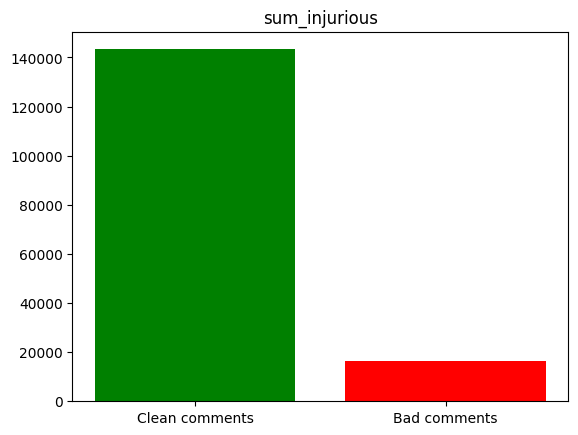

In [ ]:
clean_injurious = len(df[df["sum_injurious"] == 0])
bad_injurious = len(df[df["sum_injurious"] != 0])
print(f"clean_comment:{clean_injurious}, bad_comment:{bad_injurious}")

# Creazione del grafico a barre
plt.bar(["Clean comments", "Bad comments"], [clean_injurious, bad_injurious], color=['green', 'red'])
plt.title("sum_injurious")
plt.show()

Il dataset è sbilanciato. i commenti classificati come negativi sono molto pochi.
Verifico se ci sono duplicati o valori mancanti

In [ ]:
# Conta i valori mancanti per ogni colonna
missing_values_count = df.isna().sum()
print(missing_values_count)

# Verifico i duplicati
duplicate_rows = df.duplicated()
num_duplicates = duplicate_rows.sum()
print(f"Numero di righe duplicate: {num_duplicates}")



comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
sum_injurious    0
dtype: int64
Numero di righe duplicate: 0


Non ci sono valori mancanti ne duplicati.

#PREPROCESSING
Effettuo il preprocessing:
*   Definisco la funzione preprocess_text: Questa funzione esegue la rimozione  di punteggiatura, conversione a minuscolo, tokenizzazione, rimozione delle stopwords e lemmatizzazione.
*   Separo le features dalle label: Separo i commenti preprocessati (X) dalle etichette (y)
*   Divido il dataset in train e test: Utilizziamo train_test_split per dividere il dataset in dati di training e di test.
*   Tokenizzare e creare le sequenze: Inizializzo il tokenizer, lo adatto ai dati di training e converto i testi in sequenze.
*   Definisco il vocabolario e la lunghezza mediana per semplificare il modello
*   Applico il padding alle sequenze per uniformare la lunghezza.

In [ ]:
# Inizializzare lemmatizzatore e lista di stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Rimozione di punteggiatura e caratteri speciali
    text = re.sub(r'[^\w\s]', '', text)

    # Conversione a minuscolo
    text = text.lower()

    # Tokenizzazione
    tokens = text.split()

    # Rimozione delle stopwords e lemmatizzazione
    processed_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    # Ricostruire il testo preprocessato
    processed_text = ' '.join(processed_tokens)

    return processed_text



In [ ]:
# Preprocessare i commenti
df['cleaned_comment_text']= df['comment_text'].apply(preprocess_text)

df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious,cleaned_comment_text
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,daww match background colour im seemingly stuc...
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,hey man im really trying edit war guy constant...
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,cant make real suggestion improvement wondered...
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,sir hero chance remember page thats


In [ ]:
#visualizzo un esempio
df.iloc[56]['comment_text']
df.iloc[56]['cleaned_comment_text']

'=Tony Sidaway is obviously a fistfuckee. He loves an arm up his ass.'

'tony sidaway obviously fistfuckee love arm as'

In [ ]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious,cleaned_comment_text
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,daww match background colour im seemingly stuc...
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,hey man im really trying edit war guy constant...
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,cant make real suggestion improvement wondered...
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,sir hero chance remember page thats


In [ ]:
# Definisco X e y
X = df["cleaned_comment_text"].values
y = df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values



In [ ]:
# Dividere il dataset in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#MODELLI
Inizio con l'addestramento e la valutazione di due modelli più semplici per la classificazione di testi: la regressione logistica e il Naive Bayes. Nel primo caso utilizzo LogisticRegression con il parametro class_weight='balanced' in quanto abbiamo sbilanciamento di classi. Nel caso sei Naive Bayes addestro diversi modelli per vedere quale performa meglio.
In entrambi i casi, trasformo i testi in feature numeriche tramite TfidfVectorizer.
Inoltre, tramite OneVsRestClassifier adatterò modelli di classificazione binaria a problemi di classificazione multilabel.
Le Metriche da tenere in considerazione per la valutazione del modello sono l'F1-score, la precisione e il recall, più appropriate perché tengono conto dello sbilanciamento delle classi e della natura multilabel del problema.



##Preprocessing per Logistic regression e Naive Bayes

In [ ]:
# Utilizzo TF-IDF Vectorizer per trasformare i testi in feature numeriche
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [ ]:
#funzione per valutare il modello
def evaluate_model(model,data):
  X,y=data
  y_pred = model.predict(X)
  report=classification_report(y_pred,y)
  print(report)

##REGRESSIONE LOGISTICA

In [ ]:
# Inizializzo il modello di regressione logistica con OneVsRestClassifier bilanciando le classi
logistic_model = OneVsRestClassifier(LogisticRegression(max_iter=1000,class_weight="balanced"))
logistic_model.fit(X_train_tfidf, y_train)


OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                 max_iter=1000))

In [ ]:
print("TRAIN")
evaluate_model(logistic_model,(X_train_tfidf, y_train))
print("TEST:")
evaluate_model(logistic_model,(X_test_tfidf, y_test))

TRAIN
              precision    recall  f1-score   support

           0       0.97      0.73      0.83     16251
           1       1.00      0.34      0.51      3727
           2       1.00      0.75      0.86      8939
           3       1.00      0.34      0.51      1136
           4       1.00      0.63      0.77      9911
           5       1.00      0.33      0.49      3358

   micro avg       0.98      0.64      0.77     43322
   macro avg       0.99      0.52      0.66     43322
weighted avg       0.99      0.64      0.76     43322
 samples avg       0.10      0.08      0.08     43322

TEST:
              precision    recall  f1-score   support

           0       0.85      0.66      0.75      3977
           1       0.84      0.29      0.43       965
           2       0.88      0.68      0.77      2187
           3       0.73      0.22      0.33       306
           4       0.85      0.54      0.66      2491
           5       0.76      0.25      0.37       909

   micro av

Alcune metriche sono buone ma non per tutte le classi nonostante l'utilizzo di classe weight balanced. Provo a calcolare i pesi delle classi basati sulla frequenza delle etichette nel dataset e poi utilizzare questi pesi per bilanciare il modello.

In [ ]:
# Calcolare la frequenza delle classi nel dataset di addestramento
class_freq = np.sum(y_train, axis=0)
total_samples = y_train.shape[0]

# Calcolare i pesi inversi per bilanciare le classi
class_weights = {i: {0: 1, 1: total_samples / (2 * freq)} for i, freq in enumerate(class_freq)}

class_weights

{0: {0: 1, 1: 5.234806856393012},
 1: {0: 1, 1: 50.41706161137441},
 2: {0: 1, 1: 9.454599318619463},
 3: {0: 1, 1: 164.93023255813952},
 4: {0: 1, 1: 10.158841317841794},
 5: {0: 1, 1: 57.65853658536585}}

Le classi più rare ottengono un peso maggiore, incoraggiando il modello a prestare maggiore attenzione a queste classi.

In [ ]:
# Inizializzazione del modello di regressione logistica con OneVsRestClassifier
logistic_models = []
for i in range(y.shape[1]):
    model = LogisticRegression(max_iter=1000, class_weight=class_weights[i])
    logistic_models.append(OneVsRestClassifier(model))

# Addestramento dei modelli
for i, logistic_model in enumerate(logistic_models):
    logistic_model.fit(X_train_tfidf, y_train[:, i])

# Predizione sui dati di test
y_pred_logistic = np.zeros_like(y_test)
for i, logistic_model in enumerate(logistic_models):
    y_pred_logistic[:, i] = logistic_model.predict(X_test_tfidf)

# Valutazione del modello
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_logistic))

OneVsRestClassifier(estimator=LogisticRegression(class_weight={0: 1,
                                                               1: 5.234806856393012},
                                                 max_iter=1000))

OneVsRestClassifier(estimator=LogisticRegression(class_weight={0: 1,
                                                               1: 50.41706161137441},
                                                 max_iter=1000))

OneVsRestClassifier(estimator=LogisticRegression(class_weight={0: 1,
                                                               1: 9.454599318619463},
                                                 max_iter=1000))

OneVsRestClassifier(estimator=LogisticRegression(class_weight={0: 1,
                                                               1: 164.93023255813952},
                                                 max_iter=1000))

OneVsRestClassifier(estimator=LogisticRegression(class_weight={0: 1,
                                                               1: 10.158841317841794},
                                                 max_iter=1000))

OneVsRestClassifier(estimator=LogisticRegression(class_weight={0: 1,
                                                               1: 57.65853658536585},
                                                 max_iter=1000))

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.75      0.80      0.77      3101
           1       0.32      0.74      0.45       329
           2       0.76      0.86      0.80      1698
           3       0.29      0.66      0.40        91
           4       0.60      0.80      0.69      1594
           5       0.30      0.70      0.42       298

   micro avg       0.63      0.81      0.71      7111
   macro avg       0.50      0.76      0.59      7111
weighted avg       0.67      0.81      0.73      7111
 samples avg       0.06      0.08      0.07      7111



Le metriche migliorano. Provo ad usare un modello un pò piu complesso come il naive bayes

##2)NAIVE BAYES

Testerò i modelli multinomia e complementNB, adatti per classificazione di dati testuali, e tramite gridsearch valuterò il parametro alpha per ciascuno così da addestrare il modello migliore.

In [ ]:
# Definire i modelli di base
base_models = [MultinomialNB(), ComplementNB()]
# Definire la griglia di parametri
param_grid = {
    'estimator__alpha': [0.01, 0.1, 0.5, 1.0, 10.0]
}

# Loop attraverso ogni modello e eseguire GridSearchCV
for model in base_models:
    print(f"Running GridSearchCV for {model.__class__.__name__}...")
    grid_search = GridSearchCV(estimator=OneVsRestClassifier(model), param_grid=param_grid, cv=5, scoring='f1_weighted', verbose=1)

    # Eseguire la ricerca a griglia
    grid_search.fit(X_train_tfidf, y_train)

    # Stampare i migliori parametri trovati dalla ricerca a griglia
    print(f"Best params for {model.__class__.__name__}: {grid_search.best_params_}")

Running GridSearchCV for MultinomialNB...
Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=OneVsRestClassifier(estimator=MultinomialNB()),
             param_grid={'estimator__alpha': [0.01, 0.1, 0.5, 1.0, 10.0]},
             scoring='f1_weighted', verbose=1)

Best params for MultinomialNB: {'estimator__alpha': 0.01}
Running GridSearchCV for ComplementNB...
Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=OneVsRestClassifier(estimator=ComplementNB()),
             param_grid={'estimator__alpha': [0.01, 0.1, 0.5, 1.0, 10.0]},
             scoring='f1_weighted', verbose=1)

Best params for ComplementNB: {'estimator__alpha': 0.5}


Best Parameters
*   Multinomial alpha=0.01
*   Complement alpha=0.5

Utilizzo questi parametri per addestrare il modello





In [ ]:
# Naive Bayes Multinomial
multinomial = OneVsRestClassifier(MultinomialNB(alpha=0.01))

multinomial.fit(X_train_tfidf,y_train)
print("TRAIN")
evaluate_model(multinomial,(X_train_tfidf, y_train))
print("TEST:")
evaluate_model(multinomial,(X_test_tfidf, y_test))


OneVsRestClassifier(estimator=MultinomialNB(alpha=0.01))

TRAIN
              precision    recall  f1-score   support

           0       0.82      0.96      0.88     10436
           1       0.71      0.74      0.72      1214
           2       0.84      0.93      0.88      6128
           3       0.48      0.78      0.60       240
           4       0.81      0.89      0.85      5737
           5       0.67      0.83      0.74       890

   micro avg       0.81      0.92      0.86     24645
   macro avg       0.72      0.85      0.78     24645
weighted avg       0.81      0.92      0.86     24645
 samples avg       0.08      0.08      0.08     24645

TEST:
              precision    recall  f1-score   support

           0       0.53      0.85      0.65      1938
           1       0.25      0.47      0.33       175
           2       0.55      0.82      0.66      1138
           3       0.09      0.67      0.16        12
           4       0.48      0.73      0.58      1055
           5       0.17      0.51      0.26       100

   micro av

Il modello soffre di overfitting e le metriche sono sbilanciate. Vediamo come si comporta il ComplementNB, più adatto nel caso di sbilanciamenti.

In [ ]:
complement = OneVsRestClassifier(ComplementNB(alpha=0.5))
complement.fit(X_train_tfidf, y_train)

# Valutazione del modello sui dati di train e test
print("ComplementNB TRAIN:")
evaluate_model(complement, (X_train_tfidf, y_train))
print("ComplementNB TEST:")
evaluate_model(complement, (X_test_tfidf, y_test))

OneVsRestClassifier(estimator=ComplementNB(alpha=0.5))

ComplementNB TRAIN:
              precision    recall  f1-score   support

           0       0.65      0.76      0.70     10496
           1       0.38      0.25      0.30      1902
           2       0.65      0.65      0.65      6740
           3       0.11      0.04      0.06       980
           4       0.59      0.59      0.59      6224
           5       0.27      0.19      0.22      1575

   micro avg       0.60      0.60      0.60     27917
   macro avg       0.44      0.41      0.42     27917
weighted avg       0.58      0.60      0.59     27917
 samples avg       0.05      0.06      0.05     27917

ComplementNB TEST:
              precision    recall  f1-score   support

           0       0.53      0.76      0.63      2175
           1       0.22      0.24      0.23       290
           2       0.54      0.67      0.60      1349
           3       0.02      0.02      0.02        94
           4       0.47      0.59      0.52      1260
           5       0.16      0.23      

Le metriche peggiorano.

Conclusioni: La regressione Logistica performa meglio del naive Bayes in questo problema di classificazione multilabel ma le metriche non sono ancora ottimali. Passiamo all'utilizzo delle reti neurali ricorrenti, adatte a questo tipo di problemi.

##3) RNN model
per la RNN eseguo un ulteriore preprocessing del dataset:

Tokenizzazione e Padding: I testi vengono tokenizzati e trasformati in sequenze di numeri interi e di lunghezza uniforme.

Per la costruzione del modello creiamo una RNN che utilizza strati LSTM mentre
l'output utilizza l'attivazione sigmoid per gestire la classificazione multilabel.

In un problema di classificazione multilabel sbilanciato, è importante monitorare metriche che riflettono meglio le prestazioni del modello su classi con distribuzioni non uniformi. In questi casi, metriche come l'accuratezza possono essere fuorvianti perché potrebbero essere elevate anche se il modello non riesce a catturare bene le classi meno rappresentate. Per questo motivo, sia per Early Stopping che per compile monitoriamo come metrica l'f1 score.

##RNN_preprocessing

In [ ]:

# Inizializzare il tokenizer e adattarlo ai dati di training
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

# Convertire i testi in sequenze
train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)

# Definire il vocabolario
vocabulary_size = 10000
#Calcola la lunghezza di ogni sequenza nel set di addestramento
max_len=[len(seq)for seq in train_seq]
median_seq= int(np.median(max_len))

print("Lunghezza mediana delle sequenze nel set di addestramento:",median_seq)

Lunghezza mediana delle sequenze nel set di addestramento: 16


In [ ]:
# Padding delle sequenze
X_train_pad= pad_sequences(train_seq, maxlen=median_seq)
X_test_pad= pad_sequences(test_seq, maxlen=median_seq)

print("Dimensione del vocabolario:", vocabulary_size)
print("Forma dei dati di training dopo il padding:", X_train_pad.shape)
print("Forma dei dati di test dopo il padding:", X_test_pad.shape)


Dimensione del vocabolario: 10000
Forma dei dati di training dopo il padding: (127656, 16)
Forma dei dati di test dopo il padding: (31915, 16)


CREAZIONE DEL MODELLO

---


Inizio con un modello LSTM



In [ ]:
def evaluate_model_2(model, data):
    X, y = data
    y_pred = (model.predict(X) > 0.5).astype("int32")
    report = classification_report(y, y_pred)
    print(report)

'''def f1_score_macro(y_true, y_pred):
    y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred, axis=0)
    predicted_positives = tf.reduce_sum(y_pred, axis=0)
    possible_positives = tf.reduce_sum(y_true, axis=0)

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return tf.reduce_mean(f1)
'''

    #funzione per visualizzare la learning curve
def plot_learning_curves(hist,exp_name):
    plt.figure(figsize=(10,4))
    for subplot,curve in enumerate(['loss', "f1_score"]):
        plt.subplot(1,2,subplot+1)
        plt.plot(hist.history[curve],label='training set')
        plt.plot(hist.history['val_'+curve],label='validation')
        plt.legend()
        plt.title(exp_name+':'+curve)
    plt.tight_layout();


    # Funzione per oversampling dei dati
def oversample_data(X, y):
    from sklearn.utils import resample
    # Unisci X e y per poter resample insieme
    data = np.hstack((X, y))
    # Calcola la distribuzione delle classi
    class_counts = np.sum(y, axis=0)
    # Identifica la classe con il massimo numero di campioni
    max_class_count = np.max(class_counts)
    # Lista di dati oversampled
    oversampled_data = []
    # Esegui l'oversampling per ciascuna classe
    for i in range(y.shape[1]):
        class_data = data[y[:, i] == 1]
        if len(class_data) < max_class_count:
            class_data_oversampled = resample(class_data,
                                              replace=True,
                                              n_samples=max_class_count,
                                              random_state=42)
        else:
            class_data_oversampled = class_data

        oversampled_data.append(class_data_oversampled)
    # Combina i dati oversampled
    oversampled_data = np.vstack(oversampled_data)
    # Shuffle i dati per mescolare i campioni
    np.random.shuffle(oversampled_data)
    # Separare nuovamente X e y
    X_oversampled = oversampled_data[:, :X.shape[1]]
    y_oversampled = oversampled_data[:, X.shape[1]:]
    return X_oversampled, y_oversampled



# Definizione dell'early stopping
early_stopping = EarlyStopping(
    monitor='val_f1_score',  # Monitora il macro F1-score sul set di validazione
    patience=3,
    restore_best_weights=True
)

METRICS = [
    F1Score(name='f1_score',
            average='weighted', # use weighted average to account for labels imbalance
            threshold=0.5),
]

'def f1_score_macro(y_true, y_pred):\n    y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)\n    true_positives = tf.reduce_sum(y_true * y_pred, axis=0)\n    predicted_positives = tf.reduce_sum(y_pred, axis=0)\n    possible_positives = tf.reduce_sum(y_true, axis=0)\n\n    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())\n    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())\n\n    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())\n    return tf.reduce_mean(f1)\n'

#Modello LSTM

In [ ]:
from scikeras.wrappers import KerasClassifier

#Ricerca dei parametri migliori

In [ ]:
# Funzione per costruire il modello LSTM
def build_lstm_model(output_size, vocabulary_size, median_seq):
    print(f"Costruzione del modello con output_size={output_size}, vocabulary_size={vocabulary_size}, median_seq={median_seq}")
    model = Sequential()
    model.add(Embedding(input_dim=vocabulary_size, output_dim=output_size, input_length=median_seq))
    model.add(LSTM(units=output_size, activation='tanh'))
    model.add(Dense(units=6, activation='sigmoid'))  # Sigmoid per multietichetta
    model.summary()
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=METRICS)
    return model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV


# Parametri
vocabulary_size = 10000
median_seq = 16

# Pulizia della sessione
clear_session()

# Creazione dell'oggetto KerasClassifier
my_regressor = KerasClassifier(
    build_fn=build_lstm_model,
    vocabulary_size=vocabulary_size,
    median_seq=median_seq,
    verbose=2
)

# Definizione della griglia di parametri
grid_param_LSTM = {
    'model__output_size': [64, 128],
    'batch_size': [12, 24, 48],
    'epochs': [10]
}

# Scorer per multietichetta
scorer = make_scorer(f1_score, average='weighted')

# Creazione dell'oggetto GridSearchCV
grid_GBR = RandomizedSearchCV(estimator=my_regressor, param_distributions=grid_param_LSTM, cv=2, scoring=scorer, error_score='raise')

# Addestramento del modello
try:
    grid_GBR.fit(X_train_pad, y_train.astype("float32"))
    print("Fitting completato.")
    # Stampa dei risultati
    print("Best: %f using %s" % (grid_GBR.best_score_, grid_GBR.best_params_))
except Exception as e:
    print("Errore durante il fitting del modello con GridSearchCV:", e)


Costruzione del modello con output_size=64, vocabulary_size=10000, median_seq=16
Epoch 1/10
5319/5319 - 50s - loss: 0.0885 - f1_score: 0.5104 - 50s/epoch - 9ms/step
Epoch 2/10
5319/5319 - 21s - loss: 0.0638 - f1_score: 0.6612 - 21s/epoch - 4ms/step
Epoch 3/10
5319/5319 - 20s - loss: 0.0609 - f1_score: 0.6761 - 20s/epoch - 4ms/step
Epoch 4/10
5319/5319 - 23s - loss: 0.0594 - f1_score: 0.6848 - 23s/epoch - 4ms/step
Epoch 5/10
5319/5319 - 21s - loss: 0.0583 - f1_score: 0.6965 - 21s/epoch - 4ms/step
Epoch 6/10
5319/5319 - 20s - loss: 0.0568 - f1_score: 0.7093 - 20s/epoch - 4ms/step
Epoch 7/10
5319/5319 - 22s - loss: 0.0553 - f1_score: 0.7202 - 22s/epoch - 4ms/step
Epoch 8/10
5319/5319 - 20s - loss: 0.0533 - f1_score: 0.7304 - 20s/epoch - 4ms/step
Epoch 9/10
5319/5319 - 21s - loss: 0.0514 - f1_score: 0.7423 - 21s/epoch - 4ms/step
Epoch 10/10
5319/5319 - 20s - loss: 0.0489 - f1_score: 0.7578 - 20s/epoch - 4ms/step
5319/5319 - 11s - 11s/epoch - 2ms/step
Costruzione del modello con output_size

RandomizedSearchCV(cv=2, error_score='raise',
                   estimator=KerasClassifier(build_fn=<function build_lstm_model at 0x7da6d30d2200>, median_seq=16, verbose=2, vocabulary_size=10000),
                   param_distributions={'batch_size': [12, 24, 48],
                                        'epochs': [10],
                                        'model__output_size': [64, 128]},
                   scoring=make_scorer(f1_score, average=weighted))

Fitting completato.
Best: 0.680198 using {'model__output_size': 128, 'epochs': 10, 'batch_size': 48}


Fitting completato.
Best: 0.680198 using {'model__output_size': 128, 'epochs': 10, 'batch_size': 48}

#Modello LSTM

Utilizzo i parametri prescelti per addestrare e valutare il modello sui dati non bilanciati.

In [ ]:
# Costruisci il modello finale con i migliori parametri
best_model= build_lstm_model(
    output_size=128,
    vocabulary_size=10000,
    median_seq=16
)

# Pulizia della sessione
clear_session()

# Addestra il modello finale
history=best_model.fit(X_train_pad, y_train.astype("float32"), epochs=100, batch_size=48, verbose=2,validation_split=.2,callbacks=[early_stopping])

Costruzione del modello con output_size=128, vocabulary_size=10000, median_seq=16
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 1412358 (5.39 MB)
Trainable params: 1412358 (5.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
2128/2128 - 25s - loss: 0.0987 - f1_score: 0.5106 - val_loss: 0.0658 - val_f1_score: 0.6166 - 25s/epoch - 12ms/step
Epoch 2/100
2128/2128 - 12s - loss: 0.0619 - f1_score: 0.6586 - val_loss

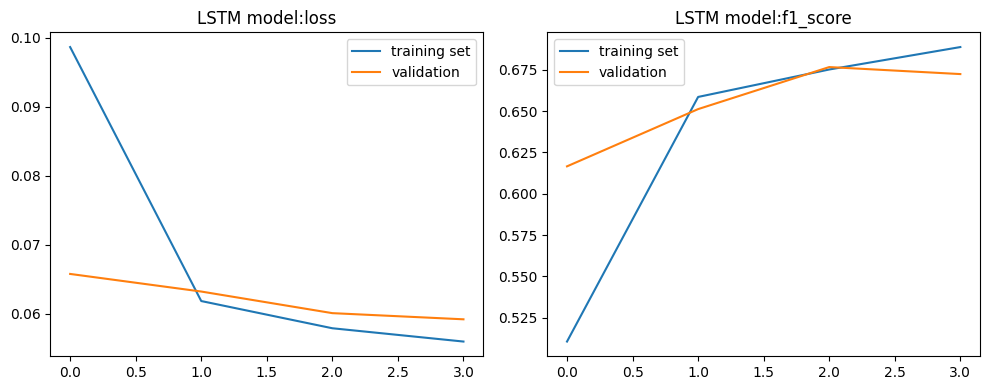

In [ ]:
plot_learning_curves(history,'LSTM model')

In [ ]:
print("TRAIN SET")
evaluate_model_2(best_model, (X_train_pad, y_train))
print("TEST SET")
evaluate_model_2(best_model, (X_test_pad, y_test))

TRAIN SET
3990/3990 [==============================] - 10s 2ms/step
              precision    recall  f1-score   support

           0       0.91      0.55      0.69     12193
           1       0.50      0.06      0.11      1266
           2       0.83      0.67      0.74      6751
           3       0.00      0.00      0.00       387
           4       0.74      0.58      0.65      6283
           5       0.00      0.00      0.00      1107

   micro avg       0.84      0.54      0.65     27987
   macro avg       0.50      0.31      0.37     27987
weighted avg       0.79      0.54      0.63     27987
 samples avg       0.05      0.04      0.04     27987

TEST SET
998/998 [==============================] - 4s 4ms/step
              precision    recall  f1-score   support

           0       0.90      0.55      0.68      3101
           1       0.42      0.05      0.09       329
           2       0.82      0.67      0.74      1698
           3       0.00      0.00      0.00        91


Le metriche sono un po' basse soprattutto la macro avg. Questo è probabilmente dovuto alle classi sbilanciate. Provo a bilanciarle con overfitting

#MODELLO LSTM con bilanciamento classi tramite oversampling

In [ ]:
# Esegui l'oversampling
X_train_oversampled, y_train_oversampled = oversample_data(X_train_pad, y_train)

In [ ]:
# Costruisci il modello finale con i migliori parametri
best_model_over = build_lstm_model(
    output_size=128,
    vocabulary_size=10000,
    median_seq=16
)

# Pulizia della sessione
clear_session()

# Addestra il modello finale
history_2=best_model_over.fit(X_train_oversampled, y_train_oversampled.astype("float32"), epochs=100, batch_size=48, verbose=2,validation_split=.2,callbacks=[early_stopping])

Costruzione del modello con output_size=128, vocabulary_size=10000, median_seq=16
Epoch 1/100
1220/1220 - 27s - loss: 0.3349 - f1_score: 0.8492 - val_loss: 0.2694 - val_f1_score: 0.8858 - 27s/epoch - 22ms/step
Epoch 2/100
1220/1220 - 13s - loss: 0.1891 - f1_score: 0.9319 - val_loss: 0.1848 - val_f1_score: 0.9262 - 13s/epoch - 10ms/step
Epoch 3/100
1220/1220 - 6s - loss: 0.1383 - f1_score: 0.9528 - val_loss: 0.1371 - val_f1_score: 0.9545 - 6s/epoch - 5ms/step
Epoch 4/100
1220/1220 - 8s - loss: 0.1114 - f1_score: 0.9632 - val_loss: 0.1237 - val_f1_score: 0.9582 - 8s/epoch - 6ms/step


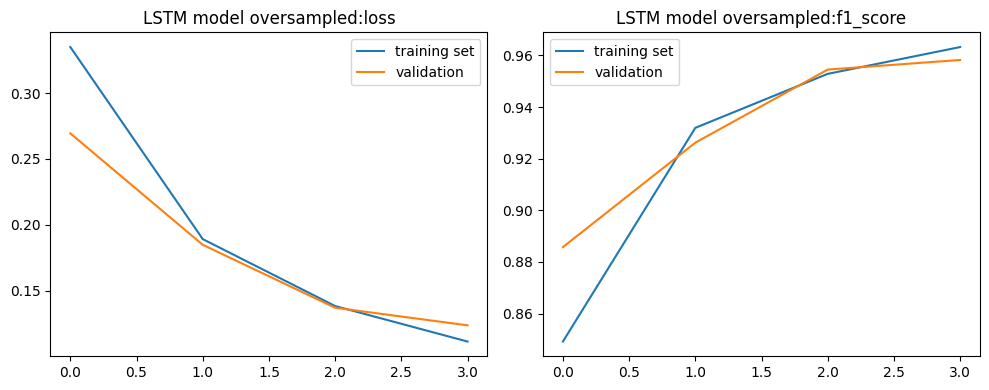

In [ ]:
plot_learning_curves(history_2,'LSTM model oversampled')

In [ ]:
print("TRAIN SET")
evaluate_model_2(best_model_over, (X_train_oversampled, y_train_oversampled))
print("TEST SET")
evaluate_model_2(best_model_over, (X_test_pad, y_test))

TRAIN SET
2287/2287 [==============================] - 11s 4ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     69888
           1       0.83      0.52      0.64     23419
           2       0.98      0.82      0.89     56345
           3       0.94      0.96      0.95     15279
           4       0.90      0.84      0.87     55354
           5       0.78      0.94      0.85     21124

   micro avg       0.92      0.87      0.89    241409
   macro avg       0.90      0.85      0.86    241409
weighted avg       0.92      0.87      0.89    241409
 samples avg       0.92      0.85      0.86    241409

TEST SET
998/998 [==============================] - 4s 3ms/step
              precision    recall  f1-score   support

           0       0.10      0.99      0.18      3101
           1       0.45      0.33      0.38       329
           2       0.53      0.69      0.60      1698
           3       0.09      0.53      0.15        91


Nonostante le learning curves seguano lo stesso andamento, le metriche visualizzare con il classification report mostrano overfitting e ancora sbilanciamento delle classi. Provo a bilanciare le classi calcolando il peso di ciascuna di esse.

#Modello LSTM con calcolo dei pesi per ciascuna classe

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight


# Calcola i pesi delle classi per ciascuna classe
class_weights = []
for i in range(y_train.shape[1]):
    class_weights.append(compute_class_weight('balanced', classes=np.unique(y_train[:, i]), y=y_train[:, i]))

class_weights = np.array(class_weights)

# Crea un array di pesi per ciascun campione
sample_weights = np.zeros(y_train.shape[0])
for i in range(y_train.shape[0]):
    sample_weights[i] = np.sum(class_weights[np.arange(y_train.shape[1]), y_train[i, :]])

# Normalizza i pesi campione
sample_weights = sample_weights / np.sum(sample_weights) * sample_weights.shape[0]


# Costruzione del modello
best_model_balanced= build_lstm_model(
    output_size=128,
    vocabulary_size=10000,
    median_seq=16
)

clear_session()
# Ora addestra il modello passando i sample_weight
history_3=best_model_balanced.fit(X_train_pad, y_train.astype("float32"), epochs=100, batch_size=64, sample_weight=sample_weights,validation_split=.2,callbacks=[early_stopping])




Costruzione del modello con output_size=128, vocabulary_size=10000, median_seq=16
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 16, 128)           1280000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 1412358 (5.39 MB)
Trainable params: 1412358 (5.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
1596/1596 [==============================] - 23s 13ms/step - loss: 0.3481 - f1_score: 0.4730 - val_loss: 0.3036 - val_f1_score: 0.6407
Epoch 2/100
1596/1596 [============================

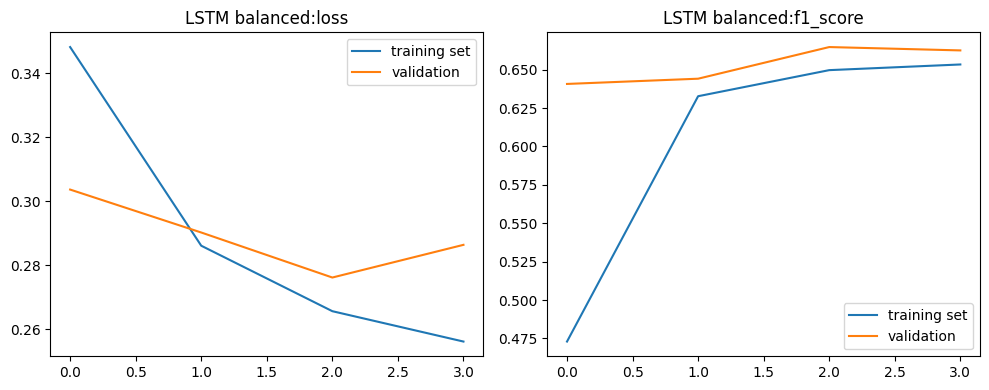

In [ ]:
plot_learning_curves(history_3,'LSTM balanced')

In [ ]:
print("TRAIN SET")
evaluate_model_2(best_model_balanced, (X_train_pad, y_train))
print("TEST SET")
evaluate_model_2(best_model_balanced, (X_test_pad, y_test))

TRAIN SET
3990/3990 [==============================] - 9s 2ms/step
              precision    recall  f1-score   support

           0       0.59      0.75      0.66     12193
           1       0.45      0.51      0.48      1266
           2       0.66      0.84      0.74      6751
           3       0.46      0.18      0.26       387
           4       0.57      0.77      0.65      6283
           5       0.42      0.39      0.41      1107

   micro avg       0.59      0.75      0.66     27987
   macro avg       0.53      0.58      0.53     27987
weighted avg       0.59      0.75      0.66     27987
 samples avg       0.06      0.07      0.06     27987

TEST SET
998/998 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.56      0.74      0.64      3101
           1       0.41      0.41      0.41       329
           2       0.63      0.82      0.71      1698
           3       0.33      0.10      0.15        91
 

Le learning curves mostrano overfitting e le performance del modello non migliorano. Provo ad aggiungere uno strato di dropout per ridurre l'overfitting.

#Modello LSTM con Dropout

In [ ]:

clear_session()
model_drop= Sequential()
model_drop.add(Embedding(input_dim=10000, output_dim=128, input_length=median_seq))
model_drop.add(Dropout(0.5))
model_drop.add(LSTM(units=128, activation='tanh'))
model_drop.add(Dense(units=6, activation='sigmoid'))  # Sigmoid per multietichetta
model_drop.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=METRICS)
model_drop.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 128)           1280000   
                                                                 
 dropout (Dropout)           (None, 16, 128)           0         
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 1412358 (5.39 MB)
Trainable params: 1412358 (5.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Ora addestra il modello passando i sample_weight
history_4=model_drop.fit(X_train_pad, y_train.astype("float32"), epochs=100, batch_size=64, sample_weight=sample_weights,validation_split=.2,callbacks=[early_stopping])

Epoch 1/100
1596/1596 [==============================] - 24s 13ms/step - loss: 0.3660 - f1_score: 0.4658 - val_loss: 0.3203 - val_f1_score: 0.6165
Epoch 2/100
1596/1596 [==============================] - 10s 6ms/step - loss: 0.3023 - f1_score: 0.5983 - val_loss: 0.3054 - val_f1_score: 0.6375
Epoch 3/100
1596/1596 [==============================] - 10s 6ms/step - loss: 0.2901 - f1_score: 0.6219 - val_loss: 0.3033 - val_f1_score: 0.6508
Epoch 4/100
1596/1596 [==============================] - 10s 6ms/step - loss: 0.2809 - f1_score: 0.6235 - val_loss: 0.3108 - val_f1_score: 0.6524


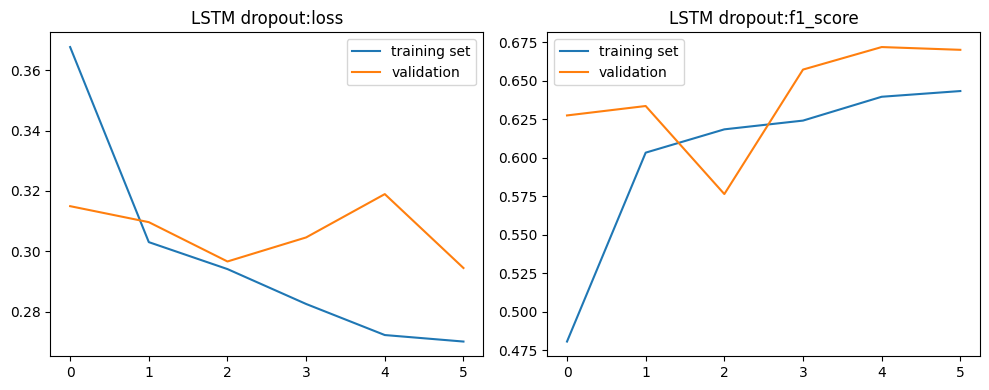

In [ ]:
plot_learning_curves(history_4,'LSTM dropout')

In [ ]:
print("TRAIN SET")
evaluate_model_2(model_drop, (X_train_pad, y_train))
print("TEST SET")
evaluate_model_2(model_drop, (X_test_pad, y_test))

TRAIN SET
3990/3990 [==============================] - 9s 2ms/step
              precision    recall  f1-score   support

           0       0.56      0.74      0.64     12193
           1       0.43      0.50      0.46      1266
           2       0.60      0.86      0.71      6751
           3       0.25      0.04      0.07       387
           4       0.55      0.79      0.65      6283
           5       0.43      0.25      0.31      1107

   micro avg       0.56      0.74      0.64     27987
   macro avg       0.47      0.53      0.47     27987
weighted avg       0.55      0.74      0.63     27987
 samples avg       0.06      0.07      0.06     27987

TEST SET
998/998 [==============================] - 3s 3ms/step
              precision    recall  f1-score   support

           0       0.54      0.72      0.62      3101
           1       0.38      0.43      0.41       329
           2       0.57      0.85      0.69      1698
           3       0.13      0.02      0.04        91
 

Anche in questo caso non ci sono grossi miglioramenti.

#Previsioni

In [ ]:
# Numero di campioni da prevedere
num_samples = 10

# Previsione sui primi 10 campioni del test set
predictions = model_drop.predict(X_test_pad[:num_samples])

# Convertire le probabilità in etichette binarie (0 o 1)
predictions_binary = (predictions > 0.5).astype("int32")

# Visualizzare i risultati
for i in range(num_samples):
    print(f"Commento: {df['comment_text'].iloc[i]}")
    print(f"Previsione (binaria): {predictions_binary[i]}")
    print(f"Etichetta Reale: {y_test[i]}")
    print("-" * 50)



1/1 [==============================] - 0s 27ms/step
Commento: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Previsione (binaria): [0 0 0 0 0 0]
Etichetta Reale: [0 0 0 0 0 0]
--------------------------------------------------
Commento: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Previsione (binaria): [0 0 0 0 0 0]
Etichetta Reale: [1 0 0 0 0 0]
--------------------------------------------------
Commento: Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
Previsione (binaria): [0 0 0 0 0 0]
Etichetta Reale: [0 0 0 0 1 0]
---